# Analytics for Unstructured Data: Assignment 1



### Forum chosen: [Edmunds Forum](https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans)





## Basic Data Cleaning


In [ ]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk import FreqDist
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
from nltk.corpus import stopwords
import re
import string
%matplotlib inline


# Read in the brand/model data andconvert it to a pandas series for easy lookup later on.
car_brands = pd.read_csv('car models and brands.csv')
car_brands = car_brands.set_index(keys='Model')
car_brands = pd.Series(car_brands['Brand'], index=car_brands.index)

# Read scraped data
df = pd.read_csv('edmunds_data.csv')

We need to ge the frequencies of all of the words, but we don't want to include punctuation so we need to do some brief cleaning first. We'll lower case all of the words, remove punctuation in both scraped data and car_brands file, and then we can get frequencies on this data.

In [ ]:
# We do not want to remove apostraphes because that would cause issues for words with contractions. 

punctuation_chars_to_remove = string.punctuation.replace("'","")
regex_pattern = "[" + punctuation_chars_to_remove + "]"
regex_pattern

'[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~]'

In [ ]:
# Lower case and remove punctuation for comments and models!

def clean_string(comment:str) -> str:
    """Send in a string and this function will lower case and strip out punctuation of the string."""
    return re.sub(regex_pattern,'', str(comment).lower())

df['cleaned_comments'] = [clean_string(comment) for comment in df.Comment.values] 
car_brands.index = [clean_string(model) for model in car_brands.index] # Don't forget to clean models too. Some have hyphens

In [ ]:
df.head()

,Unnamed: 0,Date,Comment,cleaned_comments
0,0,"March 24, 2002 10:54PM",I personally think that with a few tweaks the ...,i personally think that with a few tweaks the ...
1,1,"March 25, 2002 12:06AM",I am debating a new purchase and these two are...,i am debating a new purchase and these two are...
2,2,"March 25, 2002 10:02AM","Great handling, RWD, excellent engine and the ...",great handling rwd excellent engine and the be...
3,3,"March 25, 2002 4:04PM",And no manual tranny. That may not matter to y...,and no manual tranny that may not matter to yo...
4,4,"March 25, 2002 5:44PM",One beauty of BMW 3 Series is that there are s...,one beauty of bmw 3 series is that there are s...


In [ ]:
# To get frequency distribution of entire corpus, we combine all comments into one string, tokenize that string with nltk, and
# put the string into a df for easy manipulation.

all_text = df['cleaned_comments'].str.cat(sep=' ') # Join comments into one big string.
all_text_tokenized = word_tokenize(all_text)
freq_distribution = FreqDist(all_text_tokenized)

# Create a dataframe containing the words and their counts.
wf_df = pd.DataFrame(freq_distribution.most_common(len(freq_distribution)),columns=['word','actual_count'])
wf_df['freq*rank'] = wf_df['actual_count'] * (wf_df.index + 1) # Should be constant based on Zipf's law?

In [ ]:
wf_df.head()

,word,actual_count,freq*rank
0,the,26714,26714
1,i,12387,24774
2,a,12067,36201
3,and,10651,42604
4,to,9884,49420


## Task A: Zipf's Law

To understand if Zipf's law holds for this corpus we examine the data in two ways:

1.  We estimate the regression of: $$ ln(freq) = \beta_0 + \beta_1*ln(rank) + \epsilon$$ and examine if coefficient on $\beta_1$ is -1 as it should be if Zipf's law holds. 
   <br><br>
2.  We plot the the rank, frequncy combinations of the words that appear in all of these comments against the theoritcal line implied by Zipf's law and examine the fit.

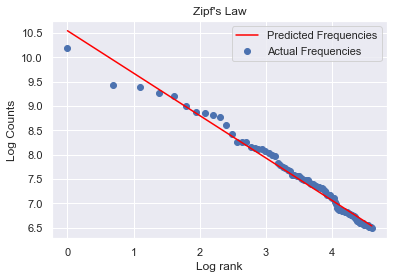

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Get log ranks and counts for top 100 words
log_ranks = np.array(np.log(range(1,len(wf_df)+1))).reshape((-1,1))[:100]
log_counts = np.log(wf_df['actual_count'])[:100]
theoretical_freqs = theoretical_freqs = (log_counts[0] + -1 * log_ranks) # Based on above formula. intercept is the natural log of most frequent word and beta_1 is negative 1

# Fit regression and get predicitions
model.fit(log_ranks,log_counts)
freqs_predicted = model.predict(log_ranks)

# Plot points and theoretical line
plt.scatter(log_ranks,log_counts, label='Actual Frequencies')
plt.plot(log_ranks,freqs_predicted,color='red',label='Predicted Frequencies')
# plt.plot(log_ranks,theoretical_freqs,color='green',label='Theoretical Frequencies')
plt.title("Zipf's Law")
plt.xlabel('Log rank')
plt.ylabel('Log Counts')
plt.legend()


We can see that our frequencies tend to be a bit higher than would be predicted.
<br><br>
We can also see this by examining the regression coefficient below. The coefficient depicted below further confirms the above plot by showing us that while our word frequencies to follow Zipf's law to an extent, the magnitude of the decrease is not as strong as Zipf's law would have predicted.

In [ ]:
print(f'Beta_1 coefficient of regression is: {model.coef_[0]}')

Beta_1 coefficient of regression is: -0.8705266531257411


## Task B: Top 10 Brands

In [ ]:
# To get brand frequencies, we will remove stop words and also replace models with their respective brands.

my_stopwords = stopwords.words('english')

def replace_models(word:str):
    """Send in a word. If that word is in our models, then return the appropriate brand. If it's not, then just return the word."""
    if word in car_brands:
        if len(car_brands[word]) >1: # If their are two possible brands, pick the first one.
            return str(car_brands[word][0])
        else:
            return str(car_brands[word])
    else:
        return word

# Function to clean each comment individually because we need it that way later.
def clean_comment_list(comments_list):
    """Send in a list of comments and output the same list of comments, but with the models replaced with brands"""

    updated_list = []
    for comment in comments_list:
        word_list = comment.split(' ') # split on space. Can't tokenize because then I would rejoin contractions with spaces. maybe not a problem?
        cleaned_comment = ' '.join([replace_models(word) for word in word_list if word not in my_stopwords]) # Clean word and then rejoin 
        updated_list.append(cleaned_comment)

    return updated_list
    

# Add these further cleaned comments to our original dataframe
df['clean_comments_no_models_or_stops'] =  clean_comment_list(df.cleaned_comments)

# To get word frequencies, we combine all of the comments into one text string, process that string with nltk's tokenizer, and
# store results in a dataframe for easy manipulation
clean_tokens = word_tokenize(df['clean_comments_no_models_or_stops'].str.cat(sep=' ')) 
cleaned_freq_distribution = FreqDist(clean_tokens)
df_freq = pd.DataFrame(cleaned_freq_distribution.most_common(len(cleaned_freq_distribution)),columns=['word','word_count'])


# Now we want to create a separate susbet of the above dataframe that only contains brands
brand_words_to_remove = ['seat','car', 'problem','sedan'] # Removing words from our model series that showed up as models, but are not actually models.
brands = car_brands.unique()
brands_only_df = df_freq[df_freq.word.isin(brands) & ~df_freq.word.isin(brand_words_to_remove)]
top_10_brands = list(brands_only_df['word'][:10].to_numpy()) # Store top 10 brands for later use. Make it a list because a later function needs it as a list.

print(brands_only_df.iloc[:10])

         word  word_count
4         bmw        1948
48      acura         541
69   infiniti         468
89       audi         377
168    toyota         254
183     honda         243
195    nissan         233
254  mercedes         188
285     volvo         167
311    subaru         147


## Task C: Lifts Between Brands

In [ ]:
# We need to calculate lifts. Big task.

# First we want to put all of the unique words into a df with words as columns
# In this data frame, each row represents a comment and each column a word.
# It will initially be filled with all zeroes which will be filled in with a loop in a bit.

all_words = set(df_freq['word']) # unique words
df_words = pd.DataFrame(np.zeros((len(df),len(all_words)))) 
df_words.columns = all_words

# Now, we will loop through each comment and word within that comment and add ones to that comment in the word column corresponding to that word. 
# Be aware this may take like 20 seconds to run!!
for index, comment in enumerate(df['clean_comments_no_models_or_stops']):
    word_list = word_tokenize(comment)
    for word in word_list:
        df_words.loc[index,word] = 1
df_words.head()

,nearentry,pm,vitural,lied,planet,thoand,backup,germanjapan,marvin,blazes,...,characature,v6',pump,sneaking,51k,525both,facelift,trims,steer,displays
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def calculate_lifts(word_list_one, word_list_two, df_words):
    """Make sure you only send in a python lists to the first two arguments!
    This function needs to list, the rows and columns of the words you want to calculate lifts between.
    It also needs a dataframe of words like we made in the above cell where each row represents a document/comment and each column represents
    a word. The words in your word list must be included in the columns of df_words.
    """
    relevant_words = sorted(list(set(word_list_one + word_list_two))) # sort it to make sure we get same df order everytime
    df_relevant_words = df_words[relevant_words] # only want to do calculations on dataframe containing the words in our list
    lift_df = pd.DataFrame(np.zeros((len(word_list_one),len(word_list_two))),columns=word_list_two,index=word_list_one) # Crreate zeroes that we will fill in with lift values

    total_comments = len(df_relevant_words) # Count how many columns there are. Needed for lift formula

    # Now to loop through each of our words, calculate their lift values and put it into the lift_df
    for word in word_list_one:
        for other_word in word_list_two:
            if word != other_word: 
                count_of_word = df_relevant_words[word].sum() # #(A)
                count_of_other_word = df_relevant_words[other_word].sum() #  #(B)
                count_of_word_and_other_word = sum((df_relevant_words[word] == 1) & (df_relevant_words[other_word] == 1)) # #(A,B)

                lift_value = (total_comments * count_of_word_and_other_word) / (count_of_word * count_of_other_word)
                lift_df.loc[word, other_word] = lift_value

    return lift_df


In [ ]:
# Calculate and display lifts between brands
brand_lifts = calculate_lifts(top_10_brands, top_10_brands, df_words)
brand_lifts


,bmw,acura,infiniti,audi,toyota,honda,nissan,mercedes,volvo,subaru
bmw,0.000000,2.016972,2.399880,2.473610,1.451696,1.397663,1.561807,2.166378,1.808455,1.417257
acura,2.016972,0.000000,4.277160,3.358710,1.967904,3.774035,2.649215,2.651204,3.855215,3.337784
infiniti,2.399880,4.277160,0.000000,3.973870,1.080314,1.690168,4.177691,2.702927,3.124186,3.217863
audi,2.473610,3.358710,3.973870,0.000000,1.312090,1.564027,2.008457,4.040404,6.482213,3.568394
toyota,1.451696,1.967904,1.080314,1.312090,0.000000,7.621106,6.143611,2.326747,2.913492,2.890452
honda,1.397663,3.774035,1.690168,1.564027,7.621106,0.000000,8.127032,1.866786,3.740065,2.261079
nissan,1.561807,2.649215,4.177691,2.008457,6.143611,8.127032,0.000000,2.018734,4.802831,2.445121
mercedes,2.166378,2.651204,2.702927,4.040404,2.326747,1.866786,2.018734,0.000000,6.340580,1.298027
volvo,1.808455,3.855215,3.124186,6.482213,2.913492,3.740065,4.802831,6.340580,0.000000,7.314100
subaru,1.417257,3.337784,3.217863,3.568394,2.890452,2.261079,2.445121,1.298027,7.314100,0.000000


<AxesSubplot:>

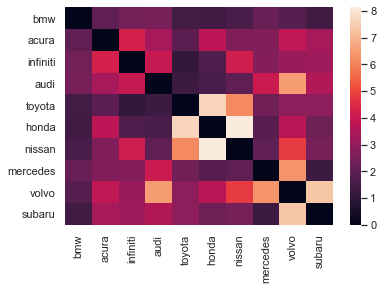

In [ ]:
sns.heatmap(brand_lifts)

## Task D: Multi-Dimensional Scaling

In [ ]:
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Create a dissimilarity matrix

df_dis = 1/brand_lifts # Get dissimilarity matrix
df_dis.values[[np.arange(df_dis.shape[0])]*2] = 0 # Make diagnols 0 so they aren't infinity

<ipython-input-20-a9805b3d7c00>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dis.values[[np.arange(df_dis.shape[0])]*2] = 0 # Make diagnols 0 so they aren't infinity


(-0.3975682942041554, 0.38381282183243737)

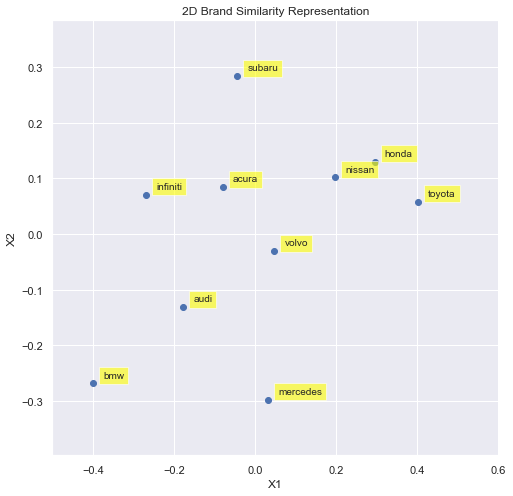

In [ ]:
# Condense above into two dimensions and plot. NEED TO MAKE GRAPH PRETTIER

mds = MDS(2,random_state=0, dissimilarity="precomputed")
X_2d = mds.fit_transform(df_dis) # Condense into two dimensions

x_vals, y_vals = X_2d[:,0],X_2d[:,1]

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x_vals, y_vals)
for i, txt in enumerate(top_10_brands):
    ax.annotate(txt,
                (x_vals[i]+.025,y_vals[i]+.01),
                # fontdict=dict(color='blue'),
                bbox=dict(facecolor='yellow',alpha=.6),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

ax.set(title='2D Brand Similarity Representation', xlabel='X1', ylabel='X2')
ax.set_xlim(x_vals.min()-.1, x_vals.max()+.2)
ax.set_ylim(y_vals.min()-.1, y_vals.max()+.1)

## Task E: Insights

Based on the information we've seen so far, we can already begin to discover some interesting patterns between car brands.
 
 
### Potentially interesting insights from Part C:
 
The strongest associations are between Toyota and Nissan (6.14), Mercedes and Volvo (6.34), Volvo and Audi (6.48), Subaru and Volvo (7.31), Honda and Toyota (7.62), and Honda and Nissan (8.13). lLift values greater than 1 indicate that the two terms appear together more frequently than expected if there was no association. Take Honda and Nissan, for example. People are 8.13 times more likely to talk about Honda when discussing Nissan and vice versa. As a marketing analytics firm, J.D. Power and Associates can use this information to improve their clients’ marketing campaigns. For example, if a client were Nissan Motor Company, their marketing department could emphasize the superiority of certain attributes, such as safety or performance, of their brand when compared to their competitors, like Nissan and Honda. Understanding with which brands people most associate your car brand is crucial for designing effective marketing campaigns to gain a competitive advantage.
 
According to the lift calculations Volvo is the brand that is mentioned the most with other top-10 brands with the highest total lift values and lifts over 3 for 7/9 brands. These findings indicate that Volvo seems to be the brand that is compared to the most regardless of luxury connotations. BMW does not get mentioned with other brands that often, but when it does it is with other luxury brands. The high lift values among the Japanese brands show that there may be more comparisons happening between Japanese brands specifically with Honda. These associations are supported in the MDS map.
 
### Potentially interesting insights from Part D:
 
The MDS map loosely groups the brands based on luxury status and manufacturing country. The European brands are on the lower half of the map with the Japanese brands in the upper half. The luxury group is on the left side with non-luxury on the right, though this pattern is not as clear as the country one. Of note Volvo is in the middle of the plot which matches the lift calculations which indicated that it is related to most of the other brands. Subaru is the only non-luxury Japanese brand that is not close to the other Japanese brands indicating that there is a distinct difference in the perception of Subaru and other Japanese brands. On another note, BMW has a clear separation from the rest of the brands in the MDS map, indicating that in the consumer mind BMW has certain aspects about its cars or its brand as a whole that separates it from the rest. Likely for BMW, a pure play luxury vehicle manufacturer, the separation indicates that BMW’s marketing campaign or brand advertising is causing consumers to think of BMW as a distinct brand with little substitutes. This is not surprising as BMW has consistently targeted high-end segments and defined every part of their brand as "premium" with great success.


## Task F: Car Attributes

The following features as the most frequently mentioned attributes: performance, luxury, engine, price, handling, and power. By examining the heatmap below, which plots the lift values of each car attribute against our top-10 brands, we can understand which attributes are associated with which brands. 

In [ ]:
# We manually go through and pick out the top 5 car attributes.
# These attributes are stored in an excel file which we read below.

top_5_attributes =  pd.read_excel('attributes.xlsx',sheet_name='attributes')
top_5_attributes = pd.Series(top_5_attributes['attributes']) # Actually more than 5 here because we picked like 14 first just to explore.
top_5_attributes.iloc[:10]

0    performance
1         luxury
2         engine
3          price
4       handling
Name: attributes, dtype: object

In [ ]:
# Now calculate lifts of the top 5 attributes. 
attribute_lifts = calculate_lifts(list(top_5_attributes), top_10_brands, df_words).iloc[:6,] # Need to select top 5 with iloc because we included like 10 to just explore
attribute_lifts

,bmw,acura,infiniti,audi,toyota,honda,nissan,mercedes,volvo,subaru
performance,1.494735,1.703176,1.683563,1.602653,1.292577,1.429879,1.502085,1.002617,0.858993,1.633384
luxury,1.372851,2.186307,1.850232,1.879469,2.664196,2.114293,1.502482,1.950687,2.442599,4.515384
engine,1.557396,1.560691,1.517702,1.843318,1.781557,1.734305,2.210374,1.840118,0.901623,1.830398
price,1.627326,1.676727,1.721908,2.005975,1.633512,1.577566,1.160061,1.304121,1.428863,1.645386
handling,1.794032,1.346983,1.247505,1.420455,1.409472,1.400090,0.908430,1.718027,0.905797,0.608450
power,1.723908,1.665992,1.429502,1.929105,0.752003,1.782607,2.004812,1.197318,1.845231,2.107142


<AxesSubplot:>

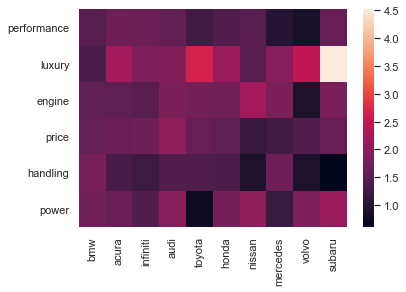

In [ ]:
sns.heatmap(attribute_lifts)

Performance is most associated with Acura. Luxury is most associated with Subaru. The engine is most associated with Nissan. Price is most associated with Audi. Handling is most associated with BMW. Amongst the top-10 brands luxury seems to have the highest association with performance and handling having generally low associations on average. Volvo has the highest association with luxury, but it has no association with performance, engine, or handling.

## Task G: Advice

* Subaru: This brand is highly associated with luxury and power. As Subaru is known for its affordable luxury sports cars and all-wheel drive SUVs, this is a good sign that consumer perception indicates that its brand mapping is working. However, Subaru is not associated with handling, which is a concern. Sports cars and all-wheel drive vehicles are generally considered to have robust handling and a large reason why people buy these cars in the first place. Subaru’s vehicles actually have good handling, but consumers do not associate the two (Lift: .61), so the marketing department must emphasize that point in their future campaigns. 

<br>

* Volvo: For the most part this brand is known for its safety and reliability. Presumably this should indicate some associations with handling and the engine, but based on these lift values there is no association. Vovlo should concentrate more on what aspects contribute to their high safety and reliability ratings to appeal to these consumers. What Volvo is doing well is marketing its luxury aspect.

<br>

* Mercedes: While Mercedes is generally advertised for its “iconic performance brand”, the brand is 2nd to the bottom when associated with performance. Furthermore the association is not statistically different from the mere occurrence of the two words appearing together (Lift: 1). This is quite troubling that Mercedes advertising is failing to push the high performance of their vehicles, especially when it is one of their biggest selling factors. Furthermore, Mercedes has the lowest association with power, which may be a consequence of the previous issue. As a result, Mercedes must push not only luxury but also the performance and their superior engine technology of their vehicles in order to remain a market leader in the luxury car market where affluent consumers expect top-of-the-line vehicles. 

* Nissan: This brand is known for its eco-friendly technological innovation which can be seen its its high association with power and the engine. It is also supposed to be known for reliability but unfortunately the association with performance is not that great when compared to other brands and the association with handling is non-existent. Since those aspects are related to reliability Nissan should put more focus on highlighting features that improve performance and handling in an attempt to demonstrate that.

* Honda: This brand is closely associated with Nissan and Toyota in the fact that they all are known for their economically friendly price, reliability and price. This can also be seen in the MDS map cluster where the measures of their similarity group them together. As a car manufacturer in a competitive market, Honda needs to differentiate itself from their close competitors. Between the three similar competitors, Honda has a similar association with a particular feature with at least one other brand. Consequently, if Honda wishes to reduce brand-switching, they need to completely revamp their marketing campaign and/or the validity of the important attributes that consumers consider important.

* Toyota: This brand produces high-quality and reliable vehicles for a reasonable price. However, the association between Toyota and price is substantially below the brand’s product design. This is the absolute epitome of Toyota sales and consumer perception is reflecting poor reception of that brand mapping. Additionally, Toyota is closely related to both Honda and Nissan. Toyota must separate themselves from these manufacturers to prevent brand-switching, which can be done through highlighting its strengths over its competitors. Based on this analysis, Toyota must explicitly highlight the advantageous price aspects of its vehicles such as: long-life, high resale value, reliability, and lower than average price. 

* Audi: This luxury brand is doing a good job marketing its luxury component as well as its technical component with high associations in the engine and power. This makes sense since they have an emphasis on quality and technology. It had moderately high associations in the other top attributes, performance and handling. The lowest association is in handling which when compared to other brands still sits well within the high-middle area. In general Audi is doing well overall when compared to other brands and as such should continue what they are doing.

* Infiniti: This brand is doing a good job in distinguishing its luxury aspect over its counterpart Nissan. It also carries a higher association with performance and handling. Although when compared to other luxury brands Infiniti falls behind in pretty much every attribute. This indicates at the company level Nissan is doing a good job separating their two divisions, but it does not stand out over other luxury brands. They should focusing on increasing their associations with the other top attributes to be more competitive amongst luxury vehicles.

* Acura: This brand is supposed to be the luxury version of Honda and as such they should have lift values that convey this. Based on these values the only thing Acura is more known for over Honda is performance and luxury, and with luxury the difference seems minimal (Honda: 2.11, Acura: 2.18). Since they are owned by the same company Acura needs to focus more on marketing their luxury component since if their luxury association is basically the same as the non-luxury brand people might as well go with the brand with higher associations in other attributes.

* BMW: There seems to be a perception of a quality driving experience with BMW boasting high associations with handling and power. Based on their marketing and company description they want to emphasise performance and luxury which is not coming through. If they want to foster this perception they should make more of an effort to emphasize their performance and luxury.

* Assuming that all the sentiments are positive in our analysis, the brands that have the strongest association with each feature, mentioned in part F, likely have either a strong marketing campaign or the brands cars truly have the best feature across the brands mentioned, at least in consumer minds. Furthermore, the features found have the highest frequency in the Edmunds discussion forum. Therefore, if we assume that consumers only discuss these attributes because they care about them when purchasing a car, it can be concluded that car manufacturers and marketing departments should focus on one or more of these topics when designing a car or campaign. If a brand, e.g. Acura, has a strong association with a feature, e.g. performance, then the brand should push that strength in their respective design and campaigns. Although, if a brand, e.g. Toyota, has very low association with a feature, e.g. power, that is important to insert into consumer perception, the brand should push marketing campaigns that emphasize that particular feature to change perception. 


## Task H: Aspirational Brands

We have identified the Subaru brand as the most aspirational. To conduct this analysis, we identified several two-word phrases that we felt indicated aspirational desires on the part of the forum commenters. You can see the aspirational phrases below:

In [ ]:
aspirational_words =  pd.read_excel('attributes.xlsx',sheet_name='aspirational')
aspirational_words = pd.Series(aspirational_words['aspirational'])
aspirational_words

0    would love
1       love to
2      dream of
3       hope to
4        aim to
5      dream to
6     desire to
7     aspire to
Name: aspirational, dtype: object

To discover which brands are associated with these phrases, we went back through each of the comments posted by edmunds’ forum users and replaced all of the aspirational phrases with the word “aspirational”. After this was done, we were able to conduct a lift analysis between the “aspirational” and our top 10 brands, similar to what we did with attributes. Our methodology and results are displayed below.

In [ ]:
# Create regex pattern that is used to find all aspiraitonal phrases in each comment.
regex_pattern = '(' + '|'.join(aspirational_words) + ')'
regex_pattern

'(would love|love to|dream of|hope to|aim to|dream to|desire to|aspire to)'

In [ ]:
# We replace all of our aspiraitonal phrases with the word 'aspirational' we do this by using a regex on the cleaned comments first
# Then we send this new cleaned comments list to our clean comment function that replaces brands with models and removes stop words
df['clean_comments_no_models_aspirational'] = clean_comment_list(df.cleaned_comments.str.replace(regex_pattern,'aspirational',regex=True))

In [ ]:
# We need to create another datafram like df_words, but that accounts for our adjusted aspirational phrases

# Create df of zeroes with words as columns and rows are comments
words_to_track = list(top_10_brands) + ['aspirational'] # Except this time, we won't get counts of every word. Just the ones we care about.
df_words_aspirational = pd.DataFrame(np.zeros((len(df), len(words_to_track))))
df_words_aspirational.columns = words_to_track

# Now fill it in
for index, comment in enumerate(df['clean_comments_no_models_aspirational']):
    word_list = word_tokenize(comment)
    for word in words_to_track:
        if word in word_list:
            df_words_aspirational.loc[index,word] = 1

# df_words_aspirational.head()

,bmw,acura,infiniti,audi,toyota,honda,nissan,mercedes,volvo,subaru,aspirational
0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
aspirational_lifts = calculate_lifts(['aspirational'], list(top_10_brands), df_words_aspirational)
aspirational_lifts

,bmw,acura,infiniti,audi,toyota,honda,nissan,mercedes,volvo,subaru
aspirational,1.466471,1.32626,1.61216,0.839161,0.396511,0.82713,0.0,0.0,1.337793,2.156722


<AxesSubplot:>

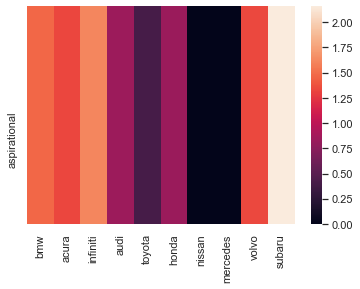

In [ ]:
sns.heatmap(aspirational_lifts)

It’s clear from the above lift values and heatmap that Subaru has the highest association with aspiration by a sizable margin. This is followed by Infiniti, BMW, Acura, and Volvo which all have lift values greater than one. Audi, Toyota, Honda, Mercedes and Nissan showed no significant associations with the aspirations of consumers.


Despite having relatively moderate associations with the previously explored, practical attributes, Subaru is still the brand that has the highest aspirational associations among forum posters on edmunds. This can be an indicator that users in general are more interested in luxury for a good price over performance or it can be seen as a testament to the marketing of the Subaru that despite its moderate association with desirable qualities people still want that brand. An extreme version of this can be seen with Volvo since it basically has no association with most of the top qualities, yet it still has a relatively high aspiration association. In general it seems that most users are aspiring for luxury over other practical attributes.

On the other side, brands like Nissan and Mercades have moderate associations with these attributes with no association with aspiration. Of the brands with no or little association with aspirations the Japanese brands not associated with luxury are included which is to be expected, but two out of three of the German luxury brands also make this list. This indicates that these German brands are not marketing themselves properly.

Overall when comparing the brand’s relative associations with the most mentioned attributes and their aspiration the biggest winners seem to be Subaru and Volvo with the biggest losers being Mercedes and Nissan. Mercedes being worse off since they are considered a luxury brand.

Another potential business implication for Subaru is that many people may want to buy the vehicle, as indicated by high aspirational associations, but do not feel they can currently afford the vehicle. This may indicate that there is substantial “springiness” in Subaru's demand curve and that by lowering the price of Subaru vehicles, sales volumes would increase by more than enough to offset the loss in per unit profit. In economic terms, Subaru’s demand is potentially highly elastic, where a 1% decrease in price would result in a larger than 1% increase in quantity sold.


